# **Rezbin AI Model v2.0 Development**

We are fine-tuning a MobileNetV2 model for a multi-class image classification of the TrashNet dataset.

In [1]:
import torch
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn, optim
from torchvision.transforms import v2
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [2]:
dataset_path = Path('../dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

In [3]:
idx_labels

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [4]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

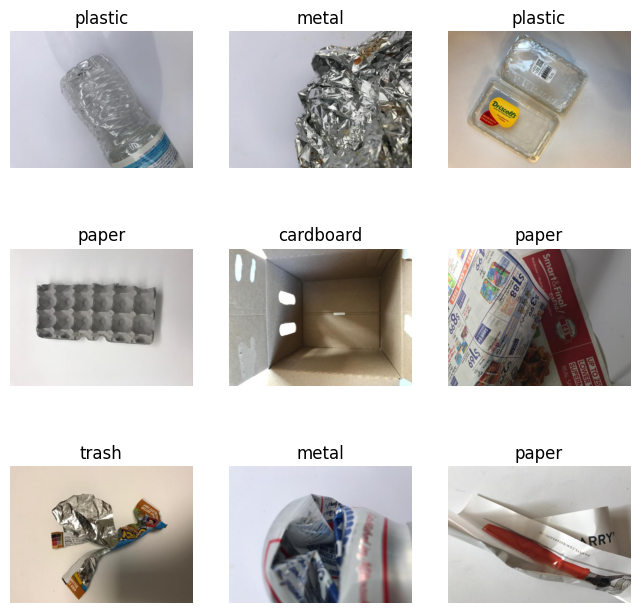

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [6]:
transform = v2.Compose([
    # augmentation steps from paper
    v2.RandomAffine(
        degrees=[-5, 5],
        translate=(0.1, 0.1),
        fill=0,
        shear=20            
    ),
    v2.RandomHorizontalFlip(p=0.5),
    
    # Transform to image
    v2.Resize((384,512)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [7]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


Feature batch shape: torch.Size([64, 3, 384, 512])
Labels batch shape: torch.Size([64])


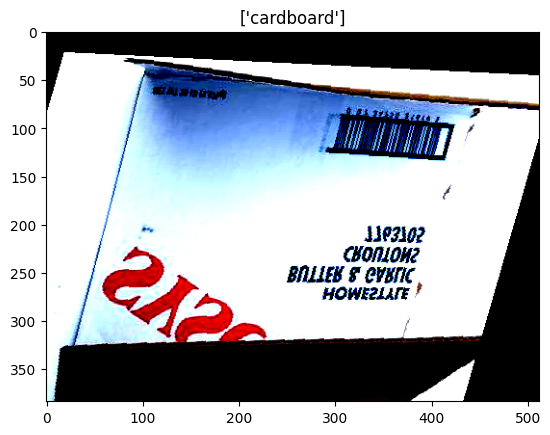

In [8]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [9]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(idx_labels))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
def compute_accuracy(preds, labels):
    _, pred_labels = preds.max(1)
    return (pred_labels == labels).sum().item() / labels.size(0)

In [11]:
def train_one_epoch(epoch, model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += acc * inputs.size(0)
        total += inputs.size(0)
        
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            correct += acc * inputs.size(0)
            total += inputs.size(0)

    return total_loss / total, correct / total

In [12]:
# For logging best results
MODEL_LOG = Path(f"../models/logs/run_{datetime.now():%Y%m%d_%H%M%S}")
MODEL_LOG.mkdir(parents=True, exist_ok=True)
CSV_LOG_PATH = MODEL_LOG / "training_log.csv"

log_df = pd.DataFrame(columns=['epoch', 'phase', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr'])

In [13]:
best_val_acc = 0.0

print("--- Preparing for Phase 1: Freezing & Preparing Hyperparameters ---")
print("🔒 PHASE 1: Training classifier head only")

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classifier's parameters
for param in model.classifier.parameters():
    param.requires_grad = True

# Define hyperparams
optimizer_p1 = optim.AdamW(model.classifier.parameters(), lr=3e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler_p1 = ReduceLROnPlateau(optimizer_p1, mode='min', patience=3)

# Ensure that the classifier head is mostly trained
# And avoid too much training time for other layers
EPOCHS_FROZEN = 100  # Train classifier only (base frozen)
EPOCHS_TOTAL = 400 + EPOCHS_FROZEN  # Fine-tune base (unfrozen) after

# This is a hyperparameter to ensure that
# the model won't overfit
best_val_loss_p1 = float('inf')
best_val_acc_p1 = 0.0
patience_p1 = int(EPOCHS_TOTAL * 0.20) # 20 percent of total epochs to end training if it has no progress for n number of times
trigger_times_p1 = 0

for epoch in range(EPOCHS_FROZEN):
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer_p1, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler_p1.step(val_loss)
    
    lr = optimizer_p1.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase1', train_loss, train_acc, val_loss, val_acc, lr]
    print(f"P1: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2} | LR: {lr} | Patience: {trigger_times_p1} / {patience_p1}")
    
    # Trigger if it performs worse
    if val_loss < best_val_loss_p1:
        best_val_loss_p1 = val_loss
        trigger_times = 0
    else:
        trigger_times_p1 += 1
        if trigger_times_p1 >= patience_p1:
            print("Early stopping PHASE 1")
            break
    
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p1_e{epoch+1}_best_model.pth")

# --- Phase 2: Fine-tuning specific feature layers and classifier ---
print("\n--- Preparing for Phase 2: Unfreezing specific feature layers ---")

# Ensure all layers are still frozen from Phase 1, then unfreeze selectively.
for param in model.parameters():
    param.requires_grad = False

# Ensure classifier is still unfrozen (important if you didn't save/load state_dict)
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze layers from features 10 to 18
for i, module in enumerate(model.features.children()):
    if 10 <= i <= 18: 
        for param in module.parameters():
            param.requires_grad = True

# Get unfrozen params
trainable_params_p2 = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params_p2.append(param)
        print(name)

# Re-create the optimizer for Phase 2 (only for unfrozen params)
optimizer_p2 = optim.AdamW(trainable_params_p2, lr=1e-5, weight_decay=1e-5)
scheduler_p2 = ReduceLROnPlateau(optimizer_p2, mode='min', patience=3)

best_val_acc_p2 = best_val_acc_p1 # Start with the best from Phase 1
best_val_loss_p2 = best_val_loss_p1 # Start with the best from Phase 1
patience_p2 = int(EPOCHS_TOTAL * 0.20) # Use the same patience calculation for consistency
trigger_times_p2 = 0

print("\n🔓 Phase 2: Fine-tuning specific feature layers and classifier")
for epoch in range(EPOCHS_FROZEN, EPOCHS_TOTAL):
    # Use the appropriate optimizer and scheduler for Phase 2
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer_p2, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler_p2.step(val_loss)
    
    lr = optimizer_p2.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase2', train_loss, train_acc, val_loss, val_acc, lr]
    print(f"P2: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2f} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2f} | LR: {lr} | Patience: {trigger_times_p2} / {patience_p2}")
    
    # Early stopping logic for Phase 2
    if val_loss < best_val_loss_p2:
        best_val_loss_p2 = val_loss
        trigger_times_p2 = 0
    else:
        trigger_times_p2 += 1
        if trigger_times_p2 >= patience_p2:
            print("Early stopping Phase 2!")
            break
    
    if val_acc > best_val_acc_p2:
        best_val_acc_p2 = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p2_e{epoch+1}_best_model.pth")

log_df.to_csv(CSV_LOG_PATH, index=False)
print(f"\n📑 Training complete. Best validation accuracy: {best_val_acc:.2%}")

--- Preparing for Phase 1: Freezing & Preparing Hyperparameters ---
🔒 PHASE 1: Training classifier head only


P1: Epoch 1 | Train Acc: 36.81% | Train Loss: 1.6 | Test Acc: 60.47% | Test Loss: 1.4 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 2 | Train Acc: 59.67% | Train Loss: 1.3 | Test Acc: 66.60% | Test Loss: 1.2 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 3 | Train Acc: 64.67% | Train Loss: 1.2 | Test Acc: 71.54% | Test Loss: 1.1 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 4 | Train Acc: 67.89% | Train Loss: 1.1 | Test Acc: 71.94% | Test Loss: 0.99 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 5 | Train Acc: 70.41% | Train Loss: 1.0 | Test Acc: 74.90% | Test Loss: 0.91 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 6 | Train Acc: 72.14% | Train Loss: 0.93 | Test Acc: 77.27% | Test Loss: 0.86 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 7 | Train Acc: 73.82% | Train Loss: 0.87 | Test Acc: 76.28% | Test Loss: 0.83 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 8 | Train Acc: 74.32% | Train Loss: 0.84 | Test Acc: 79.45% | Test Loss: 0.79 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 9 | Train Acc: 75.16% | Train Loss: 0.8 | Test Acc: 77.47% | Test Loss: 0.75 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 10 | Train Acc: 76.74% | Train Loss: 0.78 | Test Acc: 79.45% | Test Loss: 0.73 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 11 | Train Acc: 77.63% | Train Loss: 0.75 | Test Acc: 80.04% | Test Loss: 0.72 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 12 | Train Acc: 76.79% | Train Loss: 0.73 | Test Acc: 78.66% | Test Loss: 0.7 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 13 | Train Acc: 78.03% | Train Loss: 0.7 | Test Acc: 80.24% | Test Loss: 0.67 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 14 | Train Acc: 78.72% | Train Loss: 0.69 | Test Acc: 81.03% | Test Loss: 0.65 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 15 | Train Acc: 79.47% | Train Loss: 0.67 | Test Acc: 80.63% | Test Loss: 0.64 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 16 | Train Acc: 80.60% | Train Loss: 0.65 | Test Acc: 82.02% | Test Loss: 0.64 | LR: 0.0003 | Patience: 0 / 100


P1: Epoch 17 | Train Acc: 79.42% | Train Loss: 0.65 | Test Acc: 82.61% | Test Loss: 0.62 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 18 | Train Acc: 80.70% | Train Loss: 0.62 | Test Acc: 81.82% | Test Loss: 0.61 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 19 | Train Acc: 79.96% | Train Loss: 0.63 | Test Acc: 81.03% | Test Loss: 0.6 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 20 | Train Acc: 80.85% | Train Loss: 0.61 | Test Acc: 83.99% | Test Loss: 0.59 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 21 | Train Acc: 82.29% | Train Loss: 0.59 | Test Acc: 82.02% | Test Loss: 0.59 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 22 | Train Acc: 81.59% | Train Loss: 0.59 | Test Acc: 82.02% | Test Loss: 0.58 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 23 | Train Acc: 81.94% | Train Loss: 0.57 | Test Acc: 83.00% | Test Loss: 0.56 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 24 | Train Acc: 81.74% | Train Loss: 0.57 | Test Acc: 83.00% | Test Loss: 0.57 | LR: 0.0003 | Patience: 1 / 100


P1: Epoch 25 | Train Acc: 81.74% | Train Loss: 0.57 | Test Acc: 83.40% | Test Loss: 0.56 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 26 | Train Acc: 82.24% | Train Loss: 0.56 | Test Acc: 83.99% | Test Loss: 0.55 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 27 | Train Acc: 81.89% | Train Loss: 0.56 | Test Acc: 82.61% | Test Loss: 0.55 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 28 | Train Acc: 82.53% | Train Loss: 0.55 | Test Acc: 83.60% | Test Loss: 0.54 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 29 | Train Acc: 82.93% | Train Loss: 0.54 | Test Acc: 82.21% | Test Loss: 0.53 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 30 | Train Acc: 83.82% | Train Loss: 0.53 | Test Acc: 83.20% | Test Loss: 0.54 | LR: 0.0003 | Patience: 2 / 100


P1: Epoch 31 | Train Acc: 83.92% | Train Loss: 0.51 | Test Acc: 83.79% | Test Loss: 0.53 | LR: 0.0003 | Patience: 3 / 100


P1: Epoch 32 | Train Acc: 82.68% | Train Loss: 0.53 | Test Acc: 85.18% | Test Loss: 0.52 | LR: 0.0003 | Patience: 3 / 100


P1: Epoch 33 | Train Acc: 82.48% | Train Loss: 0.52 | Test Acc: 83.79% | Test Loss: 0.51 | LR: 0.0003 | Patience: 3 / 100


P1: Epoch 34 | Train Acc: 84.17% | Train Loss: 0.52 | Test Acc: 83.00% | Test Loss: 0.52 | LR: 0.0003 | Patience: 3 / 100


P1: Epoch 35 | Train Acc: 83.92% | Train Loss: 0.5 | Test Acc: 85.57% | Test Loss: 0.51 | LR: 0.0003 | Patience: 4 / 100


P1: Epoch 36 | Train Acc: 84.02% | Train Loss: 0.5 | Test Acc: 84.19% | Test Loss: 0.52 | LR: 0.0003 | Patience: 4 / 100


P1: Epoch 37 | Train Acc: 83.23% | Train Loss: 0.51 | Test Acc: 85.57% | Test Loss: 0.49 | LR: 0.0003 | Patience: 5 / 100


P1: Epoch 38 | Train Acc: 84.36% | Train Loss: 0.49 | Test Acc: 82.21% | Test Loss: 0.51 | LR: 0.0003 | Patience: 5 / 100


P1: Epoch 39 | Train Acc: 84.36% | Train Loss: 0.49 | Test Acc: 84.19% | Test Loss: 0.49 | LR: 0.0003 | Patience: 6 / 100


P1: Epoch 40 | Train Acc: 82.93% | Train Loss: 0.5 | Test Acc: 84.58% | Test Loss: 0.5 | LR: 0.0003 | Patience: 7 / 100


P1: Epoch 41 | Train Acc: 85.25% | Train Loss: 0.48 | Test Acc: 85.18% | Test Loss: 0.49 | LR: 2.9999999999999997e-05 | Patience: 8 / 100


P1: Epoch 42 | Train Acc: 84.91% | Train Loss: 0.48 | Test Acc: 84.19% | Test Loss: 0.5 | LR: 2.9999999999999997e-05 | Patience: 9 / 100


P1: Epoch 43 | Train Acc: 84.36% | Train Loss: 0.48 | Test Acc: 84.98% | Test Loss: 0.49 | LR: 2.9999999999999997e-05 | Patience: 10 / 100


P1: Epoch 44 | Train Acc: 85.11% | Train Loss: 0.47 | Test Acc: 85.97% | Test Loss: 0.49 | LR: 2.9999999999999997e-05 | Patience: 11 / 100


P1: Epoch 45 | Train Acc: 85.06% | Train Loss: 0.47 | Test Acc: 83.60% | Test Loss: 0.48 | LR: 2.9999999999999997e-05 | Patience: 12 / 100


P1: Epoch 46 | Train Acc: 84.51% | Train Loss: 0.47 | Test Acc: 83.60% | Test Loss: 0.51 | LR: 2.9999999999999997e-05 | Patience: 12 / 100


P1: Epoch 47 | Train Acc: 84.71% | Train Loss: 0.47 | Test Acc: 84.78% | Test Loss: 0.48 | LR: 2.9999999999999997e-05 | Patience: 13 / 100


P1: Epoch 48 | Train Acc: 85.60% | Train Loss: 0.48 | Test Acc: 84.58% | Test Loss: 0.48 | LR: 2.9999999999999997e-05 | Patience: 13 / 100


P1: Epoch 49 | Train Acc: 84.12% | Train Loss: 0.47 | Test Acc: 84.78% | Test Loss: 0.49 | LR: 2.9999999999999997e-05 | Patience: 13 / 100


P1: Epoch 50 | Train Acc: 85.16% | Train Loss: 0.47 | Test Acc: 84.58% | Test Loss: 0.49 | LR: 2.9999999999999997e-05 | Patience: 14 / 100


P1: Epoch 51 | Train Acc: 85.30% | Train Loss: 0.47 | Test Acc: 84.39% | Test Loss: 0.48 | LR: 2.9999999999999997e-05 | Patience: 15 / 100


P1: Epoch 52 | Train Acc: 84.91% | Train Loss: 0.48 | Test Acc: 83.79% | Test Loss: 0.5 | LR: 3e-06 | Patience: 16 / 100


P1: Epoch 53 | Train Acc: 84.81% | Train Loss: 0.47 | Test Acc: 85.18% | Test Loss: 0.47 | LR: 3e-06 | Patience: 17 / 100


P1: Epoch 54 | Train Acc: 85.11% | Train Loss: 0.47 | Test Acc: 85.18% | Test Loss: 0.49 | LR: 3e-06 | Patience: 17 / 100


P1: Epoch 55 | Train Acc: 84.61% | Train Loss: 0.47 | Test Acc: 84.78% | Test Loss: 0.49 | LR: 3e-06 | Patience: 18 / 100


P1: Epoch 56 | Train Acc: 85.40% | Train Loss: 0.46 | Test Acc: 84.58% | Test Loss: 0.48 | LR: 3e-06 | Patience: 19 / 100


P1: Epoch 57 | Train Acc: 84.96% | Train Loss: 0.47 | Test Acc: 84.39% | Test Loss: 0.48 | LR: 3.0000000000000004e-07 | Patience: 20 / 100


P1: Epoch 58 | Train Acc: 84.91% | Train Loss: 0.47 | Test Acc: 82.41% | Test Loss: 0.49 | LR: 3.0000000000000004e-07 | Patience: 21 / 100


P1: Epoch 59 | Train Acc: 84.61% | Train Loss: 0.47 | Test Acc: 83.79% | Test Loss: 0.49 | LR: 3.0000000000000004e-07 | Patience: 22 / 100


P1: Epoch 60 | Train Acc: 85.06% | Train Loss: 0.47 | Test Acc: 84.19% | Test Loss: 0.49 | LR: 3.0000000000000004e-07 | Patience: 23 / 100


P1: Epoch 61 | Train Acc: 84.36% | Train Loss: 0.48 | Test Acc: 84.19% | Test Loss: 0.5 | LR: 3.0000000000000004e-08 | Patience: 24 / 100


P1: Epoch 62 | Train Acc: 85.40% | Train Loss: 0.47 | Test Acc: 84.39% | Test Loss: 0.5 | LR: 3.0000000000000004e-08 | Patience: 25 / 100


P1: Epoch 63 | Train Acc: 84.41% | Train Loss: 0.48 | Test Acc: 84.58% | Test Loss: 0.49 | LR: 3.0000000000000004e-08 | Patience: 26 / 100


P1: Epoch 64 | Train Acc: 85.16% | Train Loss: 0.47 | Test Acc: 83.60% | Test Loss: 0.48 | LR: 3.0000000000000004e-08 | Patience: 27 / 100


P1: Epoch 65 | Train Acc: 85.85% | Train Loss: 0.46 | Test Acc: 84.78% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 28 / 100


P1: Epoch 66 | Train Acc: 85.50% | Train Loss: 0.47 | Test Acc: 84.39% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 29 / 100


P1: Epoch 67 | Train Acc: 85.75% | Train Loss: 0.47 | Test Acc: 83.79% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 30 / 100


P1: Epoch 68 | Train Acc: 84.81% | Train Loss: 0.47 | Test Acc: 83.20% | Test Loss: 0.52 | LR: 3.0000000000000004e-09 | Patience: 31 / 100


P1: Epoch 69 | Train Acc: 85.25% | Train Loss: 0.47 | Test Acc: 83.00% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 32 / 100


P1: Epoch 70 | Train Acc: 85.06% | Train Loss: 0.47 | Test Acc: 85.18% | Test Loss: 0.47 | LR: 3.0000000000000004e-09 | Patience: 33 / 100


P1: Epoch 71 | Train Acc: 85.60% | Train Loss: 0.47 | Test Acc: 83.40% | Test Loss: 0.51 | LR: 3.0000000000000004e-09 | Patience: 33 / 100


P1: Epoch 72 | Train Acc: 85.16% | Train Loss: 0.47 | Test Acc: 83.99% | Test Loss: 0.51 | LR: 3.0000000000000004e-09 | Patience: 34 / 100


P1: Epoch 73 | Train Acc: 84.96% | Train Loss: 0.48 | Test Acc: 85.18% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 35 / 100


P1: Epoch 74 | Train Acc: 84.61% | Train Loss: 0.48 | Test Acc: 85.18% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 36 / 100


P1: Epoch 75 | Train Acc: 84.61% | Train Loss: 0.47 | Test Acc: 85.57% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 37 / 100


P1: Epoch 76 | Train Acc: 85.11% | Train Loss: 0.47 | Test Acc: 85.57% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 38 / 100


P1: Epoch 77 | Train Acc: 85.55% | Train Loss: 0.47 | Test Acc: 83.99% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 39 / 100


P1: Epoch 78 | Train Acc: 84.81% | Train Loss: 0.47 | Test Acc: 85.57% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 40 / 100


P1: Epoch 79 | Train Acc: 86.05% | Train Loss: 0.47 | Test Acc: 83.99% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 41 / 100


P1: Epoch 80 | Train Acc: 84.56% | Train Loss: 0.47 | Test Acc: 85.18% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 42 / 100


P1: Epoch 81 | Train Acc: 84.46% | Train Loss: 0.48 | Test Acc: 83.99% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 43 / 100


P1: Epoch 82 | Train Acc: 85.70% | Train Loss: 0.47 | Test Acc: 85.18% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 44 / 100


P1: Epoch 83 | Train Acc: 85.21% | Train Loss: 0.47 | Test Acc: 84.58% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 45 / 100


P1: Epoch 84 | Train Acc: 85.30% | Train Loss: 0.46 | Test Acc: 85.97% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 46 / 100


P1: Epoch 85 | Train Acc: 85.80% | Train Loss: 0.46 | Test Acc: 85.57% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 47 / 100


P1: Epoch 86 | Train Acc: 85.55% | Train Loss: 0.46 | Test Acc: 85.38% | Test Loss: 0.5 | LR: 3.0000000000000004e-09 | Patience: 48 / 100


P1: Epoch 87 | Train Acc: 84.96% | Train Loss: 0.47 | Test Acc: 83.79% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 49 / 100


P1: Epoch 88 | Train Acc: 84.27% | Train Loss: 0.48 | Test Acc: 83.60% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 50 / 100


P1: Epoch 89 | Train Acc: 83.97% | Train Loss: 0.48 | Test Acc: 84.39% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 51 / 100


P1: Epoch 90 | Train Acc: 85.65% | Train Loss: 0.47 | Test Acc: 82.61% | Test Loss: 0.5 | LR: 3.0000000000000004e-09 | Patience: 52 / 100


P1: Epoch 91 | Train Acc: 85.16% | Train Loss: 0.47 | Test Acc: 85.38% | Test Loss: 0.47 | LR: 3.0000000000000004e-09 | Patience: 53 / 100


P1: Epoch 92 | Train Acc: 84.31% | Train Loss: 0.48 | Test Acc: 84.58% | Test Loss: 0.5 | LR: 3.0000000000000004e-09 | Patience: 53 / 100


P1: Epoch 93 | Train Acc: 84.41% | Train Loss: 0.47 | Test Acc: 85.57% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 54 / 100


P1: Epoch 94 | Train Acc: 85.06% | Train Loss: 0.47 | Test Acc: 83.20% | Test Loss: 0.49 | LR: 3.0000000000000004e-09 | Patience: 55 / 100


P1: Epoch 95 | Train Acc: 84.71% | Train Loss: 0.47 | Test Acc: 84.78% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 56 / 100


P1: Epoch 96 | Train Acc: 84.76% | Train Loss: 0.48 | Test Acc: 84.19% | Test Loss: 0.51 | LR: 3.0000000000000004e-09 | Patience: 57 / 100


P1: Epoch 97 | Train Acc: 85.90% | Train Loss: 0.45 | Test Acc: 85.18% | Test Loss: 0.5 | LR: 3.0000000000000004e-09 | Patience: 58 / 100


P1: Epoch 98 | Train Acc: 84.46% | Train Loss: 0.48 | Test Acc: 84.58% | Test Loss: 0.48 | LR: 3.0000000000000004e-09 | Patience: 59 / 100


P1: Epoch 99 | Train Acc: 85.35% | Train Loss: 0.47 | Test Acc: 83.79% | Test Loss: 0.47 | LR: 3.0000000000000004e-09 | Patience: 60 / 100


P1: Epoch 100 | Train Acc: 85.11% | Train Loss: 0.47 | Test Acc: 84.78% | Test Loss: 0.5 | LR: 3.0000000000000004e-09 | Patience: 61 / 100

--- Preparing for Phase 2: Unfreezing specific feature layers ---
features.10.conv.0.0.weight
features.10.conv.0.1.weight
features.10.conv.0.1.bias
features.10.conv.1.0.weight
features.10.conv.1.1.weight
features.10.conv.1.1.bias
features.10.conv.2.weight
features.10.conv.3.weight
features.10.conv.3.bias
features.11.conv.0.0.weight
features.11.conv.0.1.weight
features.11.conv.0.1.bias
features.11.conv.1.0.weight
features.11.conv.1.1.weight
features.11.conv.1.1.bias
features.11.conv.2.weight
features.11.conv.3.weight
features.11.conv.3.bias
features.12.conv.0.0.weight
features.12.conv.0.1.weight
features.12.conv.0.1.bias
features.12.conv.1.0.weight
features.12.conv.1.1.weight
features.12.conv.1.1.bias
features.12.conv.2.weight
features.12.conv.3.weight
features.12.conv.3.bias
features.13.conv.0.0.weight
features.13.conv.0.1.weight
features.13.conv.0

P2: Epoch 101 | Train Acc: 85.95% | Train Loss: 0.45 | Test Acc: 85.18% | Test Loss: 0.45 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 102 | Train Acc: 87.48% | Train Loss: 0.40 | Test Acc: 85.57% | Test Loss: 0.45 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 103 | Train Acc: 89.11% | Train Loss: 0.35 | Test Acc: 88.14% | Test Loss: 0.38 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 104 | Train Acc: 89.56% | Train Loss: 0.33 | Test Acc: 88.14% | Test Loss: 0.39 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 105 | Train Acc: 91.14% | Train Loss: 0.30 | Test Acc: 88.34% | Test Loss: 0.35 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 106 | Train Acc: 91.59% | Train Loss: 0.28 | Test Acc: 89.33% | Test Loss: 0.35 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 107 | Train Acc: 92.83% | Train Loss: 0.26 | Test Acc: 89.92% | Test Loss: 0.33 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 108 | Train Acc: 93.07% | Train Loss: 0.24 | Test Acc: 89.72% | Test Loss: 0.32 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 109 | Train Acc: 93.52% | Train Loss: 0.23 | Test Acc: 91.50% | Test Loss: 0.30 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 110 | Train Acc: 93.62% | Train Loss: 0.21 | Test Acc: 90.91% | Test Loss: 0.30 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 111 | Train Acc: 94.11% | Train Loss: 0.20 | Test Acc: 90.91% | Test Loss: 0.28 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 112 | Train Acc: 94.71% | Train Loss: 0.19 | Test Acc: 92.09% | Test Loss: 0.28 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 113 | Train Acc: 95.30% | Train Loss: 0.17 | Test Acc: 90.32% | Test Loss: 0.29 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 114 | Train Acc: 95.60% | Train Loss: 0.16 | Test Acc: 91.50% | Test Loss: 0.29 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 115 | Train Acc: 96.54% | Train Loss: 0.15 | Test Acc: 92.29% | Test Loss: 0.26 | LR: 1e-05 | Patience: 2 / 100


P2: Epoch 116 | Train Acc: 96.34% | Train Loss: 0.14 | Test Acc: 91.50% | Test Loss: 0.27 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 117 | Train Acc: 96.93% | Train Loss: 0.13 | Test Acc: 90.91% | Test Loss: 0.27 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 118 | Train Acc: 96.98% | Train Loss: 0.12 | Test Acc: 90.71% | Test Loss: 0.27 | LR: 1e-05 | Patience: 2 / 100


P2: Epoch 119 | Train Acc: 96.83% | Train Loss: 0.11 | Test Acc: 92.89% | Test Loss: 0.24 | LR: 1e-05 | Patience: 3 / 100


P2: Epoch 120 | Train Acc: 97.82% | Train Loss: 0.11 | Test Acc: 91.90% | Test Loss: 0.25 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 121 | Train Acc: 97.38% | Train Loss: 0.11 | Test Acc: 92.69% | Test Loss: 0.24 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 122 | Train Acc: 97.67% | Train Loss: 0.10 | Test Acc: 93.68% | Test Loss: 0.24 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 123 | Train Acc: 98.47% | Train Loss: 0.09 | Test Acc: 92.89% | Test Loss: 0.24 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 124 | Train Acc: 98.37% | Train Loss: 0.08 | Test Acc: 92.69% | Test Loss: 0.24 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 125 | Train Acc: 98.32% | Train Loss: 0.08 | Test Acc: 93.08% | Test Loss: 0.23 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 126 | Train Acc: 98.37% | Train Loss: 0.08 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 127 | Train Acc: 98.71% | Train Loss: 0.07 | Test Acc: 92.89% | Test Loss: 0.24 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 128 | Train Acc: 99.26% | Train Loss: 0.06 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 129 | Train Acc: 98.61% | Train Loss: 0.06 | Test Acc: 92.29% | Test Loss: 0.23 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 130 | Train Acc: 99.21% | Train Loss: 0.06 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 131 | Train Acc: 99.01% | Train Loss: 0.05 | Test Acc: 92.89% | Test Loss: 0.22 | LR: 1e-05 | Patience: 2 / 100


P2: Epoch 132 | Train Acc: 99.41% | Train Loss: 0.05 | Test Acc: 94.66% | Test Loss: 0.19 | LR: 1e-05 | Patience: 3 / 100


P2: Epoch 133 | Train Acc: 99.26% | Train Loss: 0.05 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1e-05 | Patience: 0 / 100


P2: Epoch 134 | Train Acc: 99.31% | Train Loss: 0.05 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1e-05 | Patience: 1 / 100


P2: Epoch 135 | Train Acc: 99.21% | Train Loss: 0.05 | Test Acc: 93.48% | Test Loss: 0.23 | LR: 1e-05 | Patience: 2 / 100


P2: Epoch 136 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000002e-06 | Patience: 3 / 100


P2: Epoch 137 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1.0000000000000002e-06 | Patience: 4 / 100


P2: Epoch 138 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000002e-06 | Patience: 5 / 100


P2: Epoch 139 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000002e-06 | Patience: 6 / 100


P2: Epoch 140 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.22 | LR: 1.0000000000000002e-07 | Patience: 7 / 100


P2: Epoch 141 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.23 | LR: 1.0000000000000002e-07 | Patience: 8 / 100


P2: Epoch 142 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.22 | LR: 1.0000000000000002e-07 | Patience: 9 / 100


P2: Epoch 143 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000002e-07 | Patience: 10 / 100


P2: Epoch 144 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 145 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 146 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 147 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 148 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 149 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 16 / 100


P2: Epoch 150 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 17 / 100


P2: Epoch 151 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 18 / 100


P2: Epoch 152 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 19 / 100


P2: Epoch 153 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 20 / 100


P2: Epoch 154 | Train Acc: 99.75% | Train Loss: 0.03 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 21 / 100


P2: Epoch 155 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 22 / 100


P2: Epoch 156 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 23 / 100


P2: Epoch 157 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 24 / 100


P2: Epoch 158 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 25 / 100


P2: Epoch 159 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 26 / 100


P2: Epoch 160 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 27 / 100


P2: Epoch 161 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 0 / 100


P2: Epoch 162 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 1 / 100


P2: Epoch 163 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 2 / 100


P2: Epoch 164 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 3 / 100


P2: Epoch 165 | Train Acc: 99.21% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 4 / 100


P2: Epoch 166 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 5 / 100


P2: Epoch 167 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 6 / 100


P2: Epoch 168 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 7 / 100


P2: Epoch 169 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 8 / 100


P2: Epoch 170 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 9 / 100


P2: Epoch 171 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 10 / 100


P2: Epoch 172 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 173 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 174 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 175 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 176 | Train Acc: 99.31% | Train Loss: 0.05 | Test Acc: 94.27% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 177 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 0 / 100


P2: Epoch 178 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 1 / 100


P2: Epoch 179 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 2 / 100


P2: Epoch 180 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 3 / 100


P2: Epoch 181 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 4 / 100


P2: Epoch 182 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 5 / 100


P2: Epoch 183 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 6 / 100


P2: Epoch 184 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 7 / 100


P2: Epoch 185 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 8 / 100


P2: Epoch 186 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 9 / 100


P2: Epoch 187 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.49% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 10 / 100


P2: Epoch 188 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 189 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 190 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 191 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 192 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 193 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 16 / 100


P2: Epoch 194 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 17 / 100


P2: Epoch 195 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 18 / 100


P2: Epoch 196 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 0 / 100


P2: Epoch 197 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 1 / 100


P2: Epoch 198 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 2 / 100


P2: Epoch 199 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 3 / 100


P2: Epoch 200 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 4 / 100


P2: Epoch 201 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 92.49% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 5 / 100


P2: Epoch 202 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 92.29% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 6 / 100


P2: Epoch 203 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 7 / 100


P2: Epoch 204 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 95.06% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 8 / 100


P2: Epoch 205 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 9 / 100


P2: Epoch 206 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.29% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 10 / 100


P2: Epoch 207 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 208 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 209 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 210 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 211 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 212 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 16 / 100


P2: Epoch 213 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 17 / 100


P2: Epoch 214 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 18 / 100


P2: Epoch 215 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 19 / 100


P2: Epoch 216 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 20 / 100


P2: Epoch 217 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 21 / 100


P2: Epoch 218 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 22 / 100


P2: Epoch 219 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 23 / 100


P2: Epoch 220 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 24 / 100


P2: Epoch 221 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 25 / 100


P2: Epoch 222 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 26 / 100


P2: Epoch 223 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 27 / 100


P2: Epoch 224 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 28 / 100


P2: Epoch 225 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 29 / 100


P2: Epoch 226 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 30 / 100


P2: Epoch 227 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 31 / 100


P2: Epoch 228 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 32 / 100


P2: Epoch 229 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 33 / 100


P2: Epoch 230 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 34 / 100


P2: Epoch 231 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 35 / 100


P2: Epoch 232 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.86% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 36 / 100


P2: Epoch 233 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 37 / 100


P2: Epoch 234 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 38 / 100


P2: Epoch 235 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 39 / 100


P2: Epoch 236 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 40 / 100


P2: Epoch 237 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 95.45% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 41 / 100


P2: Epoch 238 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 42 / 100


P2: Epoch 239 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 43 / 100


P2: Epoch 240 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 44 / 100


P2: Epoch 241 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 45 / 100


P2: Epoch 242 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 46 / 100


P2: Epoch 243 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 92.49% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 47 / 100


P2: Epoch 244 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.29% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 48 / 100


P2: Epoch 245 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 49 / 100


P2: Epoch 246 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 50 / 100


P2: Epoch 247 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 51 / 100


P2: Epoch 248 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 52 / 100


P2: Epoch 249 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 53 / 100


P2: Epoch 250 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 54 / 100


P2: Epoch 251 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 55 / 100


P2: Epoch 252 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 92.49% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 56 / 100


P2: Epoch 253 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 57 / 100


P2: Epoch 254 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 58 / 100


P2: Epoch 255 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.86% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 59 / 100


P2: Epoch 256 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 60 / 100


P2: Epoch 257 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 61 / 100


P2: Epoch 258 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 62 / 100


P2: Epoch 259 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 92.09% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 63 / 100


P2: Epoch 260 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 64 / 100


P2: Epoch 261 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 65 / 100


P2: Epoch 262 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 66 / 100


P2: Epoch 263 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 67 / 100


P2: Epoch 264 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 68 / 100


P2: Epoch 265 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 69 / 100


P2: Epoch 266 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 70 / 100


P2: Epoch 267 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 71 / 100


P2: Epoch 268 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 72 / 100


P2: Epoch 269 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 73 / 100


P2: Epoch 270 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 74 / 100


P2: Epoch 271 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 75 / 100


P2: Epoch 272 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 76 / 100


P2: Epoch 273 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 77 / 100


P2: Epoch 274 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 78 / 100


P2: Epoch 275 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 79 / 100


P2: Epoch 276 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 80 / 100


P2: Epoch 277 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 81 / 100


P2: Epoch 278 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 82 / 100


P2: Epoch 279 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 83 / 100


P2: Epoch 280 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 84 / 100


P2: Epoch 281 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 85 / 100


P2: Epoch 282 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 86 / 100


P2: Epoch 283 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 87 / 100


P2: Epoch 284 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 88 / 100


P2: Epoch 285 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 89 / 100


P2: Epoch 286 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 90 / 100


P2: Epoch 287 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 91 / 100


P2: Epoch 288 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 92 / 100


P2: Epoch 289 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 93 / 100


P2: Epoch 290 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 94 / 100


P2: Epoch 291 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 95 / 100


P2: Epoch 292 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 96 / 100


P2: Epoch 293 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 97 / 100


P2: Epoch 294 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 98 / 100


P2: Epoch 295 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 0 / 100


P2: Epoch 296 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 1 / 100


P2: Epoch 297 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 2 / 100


P2: Epoch 298 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 3 / 100


P2: Epoch 299 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 4 / 100


P2: Epoch 300 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 5 / 100


P2: Epoch 301 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 6 / 100


P2: Epoch 302 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 7 / 100


P2: Epoch 303 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.49% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 8 / 100


P2: Epoch 304 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 9 / 100


P2: Epoch 305 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 10 / 100


P2: Epoch 306 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 307 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 308 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 309 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 310 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 311 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 16 / 100


P2: Epoch 312 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.18 | LR: 1.0000000000000004e-08 | Patience: 17 / 100


P2: Epoch 313 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 0 / 100


P2: Epoch 314 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 1 / 100


P2: Epoch 315 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 2 / 100


P2: Epoch 316 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.86% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 3 / 100


P2: Epoch 317 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 4 / 100


P2: Epoch 318 | Train Acc: 99.16% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.18 | LR: 1.0000000000000004e-08 | Patience: 5 / 100


P2: Epoch 319 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 6 / 100


P2: Epoch 320 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 7 / 100


P2: Epoch 321 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 8 / 100


P2: Epoch 322 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 9 / 100


P2: Epoch 323 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 10 / 100


P2: Epoch 324 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 11 / 100


P2: Epoch 325 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 12 / 100


P2: Epoch 326 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 13 / 100


P2: Epoch 327 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 14 / 100


P2: Epoch 328 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 15 / 100


P2: Epoch 329 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 16 / 100


P2: Epoch 330 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 17 / 100


P2: Epoch 331 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 95.26% | Test Loss: 0.18 | LR: 1.0000000000000004e-08 | Patience: 18 / 100


P2: Epoch 332 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 19 / 100


P2: Epoch 333 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 20 / 100


P2: Epoch 334 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 21 / 100


P2: Epoch 335 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 22 / 100


P2: Epoch 336 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 23 / 100


P2: Epoch 337 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 24 / 100


P2: Epoch 338 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 25 / 100


P2: Epoch 339 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 26 / 100


P2: Epoch 340 | Train Acc: 99.31% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 27 / 100


P2: Epoch 341 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 28 / 100


P2: Epoch 342 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 29 / 100


P2: Epoch 343 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 30 / 100


P2: Epoch 344 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 31 / 100


P2: Epoch 345 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 32 / 100


P2: Epoch 346 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 33 / 100


P2: Epoch 347 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 34 / 100


P2: Epoch 348 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 35 / 100


P2: Epoch 349 | Train Acc: 99.21% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 36 / 100


P2: Epoch 350 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 37 / 100


P2: Epoch 351 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 95.06% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 38 / 100


P2: Epoch 352 | Train Acc: 99.21% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 39 / 100


P2: Epoch 353 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 40 / 100


P2: Epoch 354 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 41 / 100


P2: Epoch 355 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 42 / 100


P2: Epoch 356 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 43 / 100


P2: Epoch 357 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 95.06% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 44 / 100


P2: Epoch 358 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 45 / 100


P2: Epoch 359 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 46 / 100


P2: Epoch 360 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 47 / 100


P2: Epoch 361 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 94.27% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 48 / 100


P2: Epoch 362 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 49 / 100


P2: Epoch 363 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 50 / 100


P2: Epoch 364 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 51 / 100


P2: Epoch 365 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.86% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 52 / 100


P2: Epoch 366 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 53 / 100


P2: Epoch 367 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 54 / 100


P2: Epoch 368 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 55 / 100


P2: Epoch 369 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 56 / 100


P2: Epoch 370 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 57 / 100


P2: Epoch 371 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 58 / 100


P2: Epoch 372 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 59 / 100


P2: Epoch 373 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 60 / 100


P2: Epoch 374 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 61 / 100


P2: Epoch 375 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 62 / 100


P2: Epoch 376 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 63 / 100


P2: Epoch 377 | Train Acc: 99.80% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 64 / 100


P2: Epoch 378 | Train Acc: 99.21% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 65 / 100


P2: Epoch 379 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 66 / 100


P2: Epoch 380 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 94.86% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 67 / 100


P2: Epoch 381 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 68 / 100


P2: Epoch 382 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 69 / 100


P2: Epoch 383 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 70 / 100


P2: Epoch 384 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 71 / 100


P2: Epoch 385 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 72 / 100


P2: Epoch 386 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 73 / 100


P2: Epoch 387 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 74 / 100


P2: Epoch 388 | Train Acc: 99.85% | Train Loss: 0.04 | Test Acc: 91.90% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 75 / 100


P2: Epoch 389 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 76 / 100


P2: Epoch 390 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 77 / 100


P2: Epoch 391 | Train Acc: 99.26% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 78 / 100


P2: Epoch 392 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 79 / 100


P2: Epoch 393 | Train Acc: 99.41% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 80 / 100


P2: Epoch 394 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 81 / 100


P2: Epoch 395 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.28% | Test Loss: 0.23 | LR: 1.0000000000000004e-08 | Patience: 82 / 100


P2: Epoch 396 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 83 / 100


P2: Epoch 397 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 84 / 100


P2: Epoch 398 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 92.69% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 85 / 100


P2: Epoch 399 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 86 / 100


P2: Epoch 400 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 87 / 100


P2: Epoch 401 | Train Acc: 99.36% | Train Loss: 0.04 | Test Acc: 94.66% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 88 / 100


P2: Epoch 402 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 92.89% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 89 / 100


P2: Epoch 403 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 90 / 100


P2: Epoch 404 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 91 / 100


P2: Epoch 405 | Train Acc: 99.46% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 92 / 100


P2: Epoch 406 | Train Acc: 99.51% | Train Loss: 0.04 | Test Acc: 94.07% | Test Loss: 0.22 | LR: 1.0000000000000004e-08 | Patience: 93 / 100


P2: Epoch 407 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.08% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 94 / 100


P2: Epoch 408 | Train Acc: 99.70% | Train Loss: 0.04 | Test Acc: 93.87% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 95 / 100


P2: Epoch 409 | Train Acc: 99.60% | Train Loss: 0.04 | Test Acc: 94.47% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 96 / 100


P2: Epoch 410 | Train Acc: 99.65% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.19 | LR: 1.0000000000000004e-08 | Patience: 97 / 100


P2: Epoch 411 | Train Acc: 99.55% | Train Loss: 0.04 | Test Acc: 93.48% | Test Loss: 0.20 | LR: 1.0000000000000004e-08 | Patience: 98 / 100


P2: Epoch 412 | Train Acc: 99.75% | Train Loss: 0.04 | Test Acc: 93.68% | Test Loss: 0.21 | LR: 1.0000000000000004e-08 | Patience: 99 / 100
Early stopping Phase 2!

📑 Training complete. Best validation accuracy: 0.00%


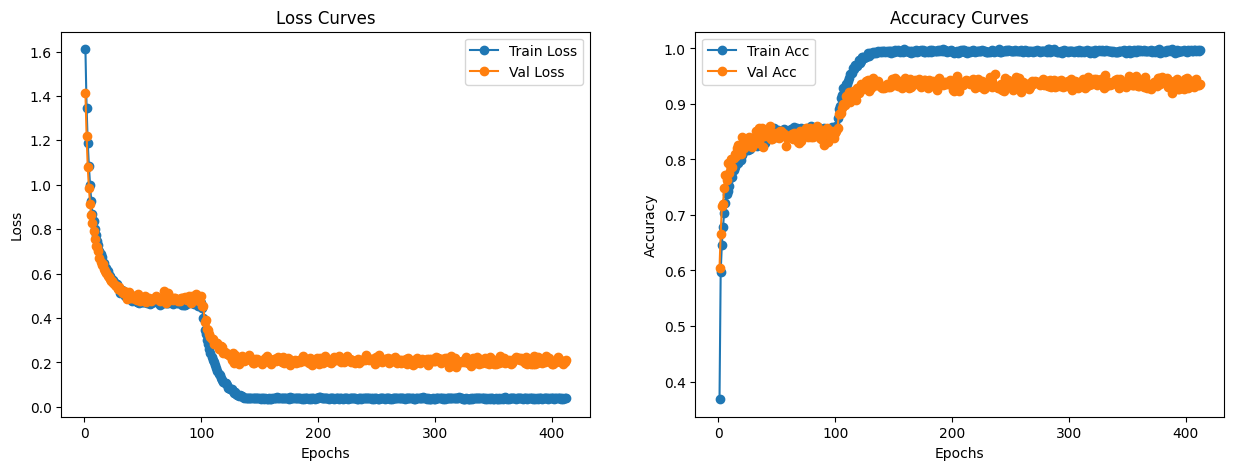

In [14]:
import matplotlib.pyplot as plt

# Assuming log_df contains your training logs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', marker='o')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
ax2.plot(log_df['epoch'], log_df['train_acc'], label='Train Acc', marker='o')
ax2.plot(log_df['epoch'], log_df['val_acc'], label='Val Acc', marker='o')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.savefig(MODEL_LOG / "output.jpg")
plt.show()